In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
np.random.seed(42)

# Données de coût de construction et maintenance
cout_digue = {
    0.1: 100, 0.5: 150, 1: 424, 2: 1200, 3: 2205, 4: 3394,
    5: 4338, 6: 5302, 7: 6282, 8: 7275, 9: 8282, 10: 9300
}
longueur_digue = {
    0.1: 1000, 0.5: 1500, 1: 2437, 2: 3959, 3: 5000,
    4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000, 10: 5000
}

# Coût des dommages
dommages_site = {
    -0.1: 0, 0: 0, 0.5: 150, 1: 1500, 1.5: 2000, 2: 2000
}
dommages_digue = {
    -0.1: 0, 0: 0.1, 0.5: 0.5, 1: 1, 1.5: 1, 2: 1
}

# Paramètres généraux
T = 30  # Durée d'exploitation (années)
maintenance_ratio = 0.01  # Coût de maintenance annuel (% de Ci)

In [78]:
L = 5000 
B = 300   
Zb = 50
N = 5000 # Arbitraire

Q_samples = np.zeros(N)
Ks_samples = np.zeros(N)
Zv_samples = np.zeros(N)
Zm_samples = np.zeros(N)
H_samples = np.zeros(N)
S_samples = np.zeros(N)

# Conditions initiales posées arbitrairement
Q_samples[0] = 1013  
Ks_samples[0] = 30   
Zv_samples[0] = 50   
Zm_samples[0] = 55 

def gumbel_pdf(x, mode=1013, beta=558):
    return (1/beta) * np.exp(-(x - mode) / beta) * np.exp(-np.exp(-(x - mode) / beta))

def normal_pdf(x, mu=30, sigma=7.5):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def triangular_pdf(x, lower, upper, mode):
    if lower <= x <= mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode < x <= upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))
    else:
        return 0
    
# Metropolis-Hastings
for i in range(1, N):

    Q_prop = max(0.1, np.random.normal(Q_samples[i-1], 50))  
    Ks_prop = max(0.1, np.random.normal(Ks_samples[i-1], 2))
    Zv_prop = np.random.normal(Zv_samples[i-1], 0.5)
    Zm_prop = max(Zv_prop + 0.1, np.random.normal(Zm_samples[i-1], 0.5))  # Assure Zm > Zv

    alpha_Q = min(1, gumbel_pdf(Q_prop) / gumbel_pdf(Q_samples[i-1]))
    alpha_Ks = min(1, normal_pdf(Ks_prop) / normal_pdf(Ks_samples[i-1]))
    alpha_Zv = min(1, triangular_pdf(Zv_prop, 49, 51, 50) / triangular_pdf(Zv_samples[i-1], 49, 51, 50))
    alpha_Zm = min(1, triangular_pdf(Zm_prop, 54, 56, 55) / triangular_pdf(Zm_samples[i-1], 54, 56, 55))

    Q_samples[i] = Q_prop if np.random.rand() < alpha_Q else Q_samples[i-1]
    Ks_samples[i] = Ks_prop if np.random.rand() < alpha_Ks else Ks_samples[i-1]
    Zv_samples[i] = Zv_prop if np.random.rand() < alpha_Zv else Zv_samples[i-1]
    Zm_samples[i] = Zm_prop if np.random.rand() < alpha_Zm else Zm_samples[i-1]

    # H
    delta_Z = max(0.001, Zm_samples[i] - Zv_samples[i])  # Empêche une valeur négative
    H_samples[i] = (Q_samples[i] / (Ks_samples[i] * np.sqrt(delta_Z / L) * B)) ** (3/5)

In [79]:
def calcul_cout_digue(hd):
    if hd not in cout_digue:
        return None
    Ci = cout_digue[hd] * longueur_digue[hd] / 1000  # En k€
    Cm = maintenance_ratio * Ci
    Ct = Ci + T * Cm  # Coût total sur la durée d’exploitation
    return Ci, Cm, Ct

# Vérification des coûts
hauteurs_test = sorted(cout_digue.keys())
couts_digue = {hd: calcul_cout_digue(hd) for hd in hauteurs_test}

df_couts_digue = pd.DataFrame.from_dict(couts_digue, orient='index', columns=["Ci (k€)", "Cm (k€/an)", "Ct (k€)"])
df_couts_digue

,Ci (k€),Cm (k€/an),Ct (k€)
0.1,100.000,1.00000,130.0000
0.5,225.000,2.25000,292.5000
1.0,1033.288,10.33288,1343.2744
2.0,4750.800,47.50800,6176.0400
3.0,11025.000,110.25000,14332.5000
4.0,16970.000,169.70000,22061.0000
5.0,21690.000,216.90000,28197.0000
6.0,26510.000,265.10000,34463.0000
7.0,31410.000,314.10000,40833.0000
8.0,36375.000,363.75000,47287.5000


In [80]:
# Chargement des résultats du modèle hydraulique
N = 5000
S_samples_dict = {}

for hd in hauteurs_test:
    S_samples = Zv_samples + H_samples - hd - Zb
    S_samples_dict[hd] = S_samples

def calcul_cout_dommages(S_samples, hd):
    """Calcule les coûts moyens de dommages pour une hauteur de digue donnée."""
    Cd_samples = np.zeros(N)

    for i in range(N):
        S = S_samples[i]
        S_discret = min(dommages_site.keys(), key=lambda x: abs(x - S))  # Trouver la valeur discrète la plus proche
        Cs = dommages_site[S_discret]  # Coût de dommage au site
        Cg = dommages_digue[S_discret] * cout_digue[hd] * longueur_digue[hd] / 1000  # Coût de dommage à la digue
        Cd_samples[i] = Cs + Cg

    return np.mean(Cd_samples)

# Calcul des coûts de dommages pour chaque hauteur de digue
couts_dommages = {hd: calcul_cout_dommages(S_samples_dict[hd], hd) for hd in hauteurs_test}

df_couts_dommages = pd.DataFrame.from_dict(couts_dommages, orient='index', columns=["Coût dommages annuel (k€)"])
df_couts_dommages

,Coût dommages annuel (k€)
0.1,1943.556000
0.5,1894.394500
1.0,2179.240916
2.0,2412.144600
3.0,1149.896000
4.0,213.554200
5.0,69.853800
6.0,26.739600
7.0,16.535000
8.0,15.150000


In [81]:
# Calcul du coût complet moyen
couts_complets = {}

for hd in hauteurs_test:
    Ct = couts_digue[hd][2]  # Coût total de la digue
    Cd_moy = couts_dommages[hd]  # Coût moyen des dommages annuels
    Cc_moy = (Ct + T * Cd_moy) / T  # Coût complet moyen

    couts_complets[hd] = Cc_moy

df_couts_complets = pd.DataFrame.from_dict(couts_complets, orient='index', columns=["Coût complet moyen (k€/an)"])
df_couts_complets

,Coût complet moyen (k€/an)
0.1,1947.889333
0.5,1904.144500
1.0,2224.016729
2.0,2618.012600
3.0,1627.646000
4.0,948.920867
5.0,1009.753800
6.0,1175.506267
7.0,1377.635000
8.0,1591.400000


In [82]:
P_inondation_hd = {}
for hd_test in hauteurs_test:
    S_samples = Zv_samples + H_samples - hd_test - Zb
    P_inondation = np.mean(S_samples > 0)
    P_inondation_hd[hd_test] = P_inondation

In [92]:
seuil_max_p_inondation_1 = 0.1

# Filtrer les hauteurs qui respectent la contrainte sur P(S > 0)
hauteurs_viables_1 = [hd for hd in hauteurs_test if P_inondation_hd[hd] < seuil_max_p_inondation_1]

# Trouver la hauteur parmi celles qui respectent la contrainte et qui minimise le coût
if hauteurs_viables_1:
    hauteur_optimale_1 = min(hauteurs_viables_1, key=lambda hd: couts_complets[hd])
    print(f"✅ Hauteur optimale sous contrainte P(S > 0) < {seuil_max_p_inondation_1*100}% : {hauteur_optimale_1:.2f} m")
else:
    print("⚠️ Aucune hauteur ne satisfait la contrainte de probabilité d'inondation.")

✅ Hauteur optimale sous contrainte P(S > 0) < 10.0% : 4.00 m


In [93]:
seuil_max_p_inondation_2 = 0.01

# Filtrer les hauteurs qui respectent la contrainte sur P(S > 0)
hauteurs_viables_2 = [hd for hd in hauteurs_test if P_inondation_hd[hd] < seuil_max_p_inondation_2]

# Trouver la hauteur parmi celles qui respectent la contrainte et qui minimise le coût
if hauteurs_viables_2:
    hauteur_optimale_2 = min(hauteurs_viables_2, key=lambda hd: couts_complets[hd])
    print(f"✅ Hauteur optimale sous contrainte P(S > 0) < {seuil_max_p_inondation_2*100}% : {hauteur_optimale_2:.2f} m")
else:
    print("⚠️ Aucune hauteur ne satisfait la contrainte de probabilité d'inondation.")

✅ Hauteur optimale sous contrainte P(S > 0) < 1.0% : 5.00 m


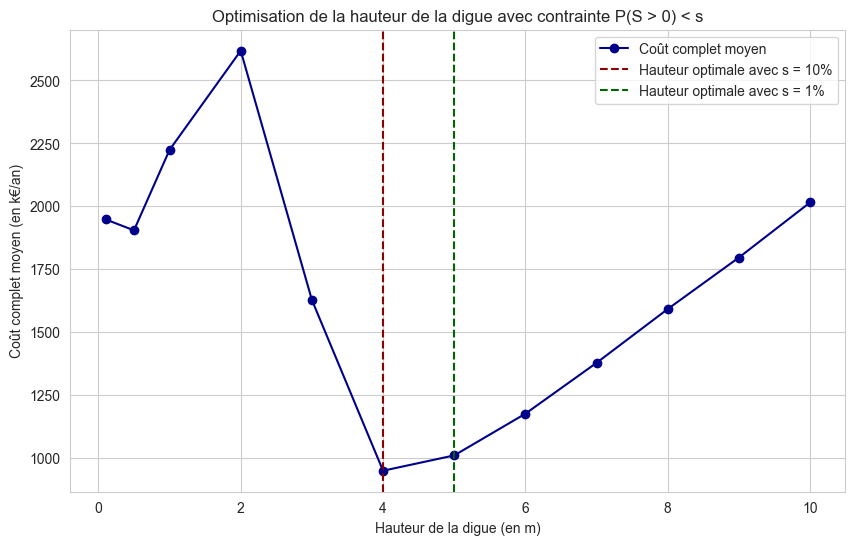

In [100]:
plt.figure(figsize=(10,6))

# Courbe du coût complet moyen
plt.plot(hauteurs_test, list(couts_complets.values()), marker='o', label="Coût complet moyen", color="darkblue")

# Ligne pour la hauteur optimale sélectionnée
if hauteurs_viables_1:
    plt.axvline(x=hauteur_optimale_1, color="darkred", linestyle="--", label=f"Hauteur optimale avec s = {seuil_max_p_inondation_1:.0%}")
if hauteurs_viables_2:
    plt.axvline(x=hauteur_optimale_2, color="darkgreen", linestyle="--", label=f"Hauteur optimale avec s = {seuil_max_p_inondation_2:.0%}")


plt.xlabel("Hauteur de la digue (en m)")
plt.ylabel("Coût complet moyen (en k€/an)")
plt.title("Optimisation de la hauteur de la digue avec contrainte P(S > 0) < s")
plt.legend()
plt.show()

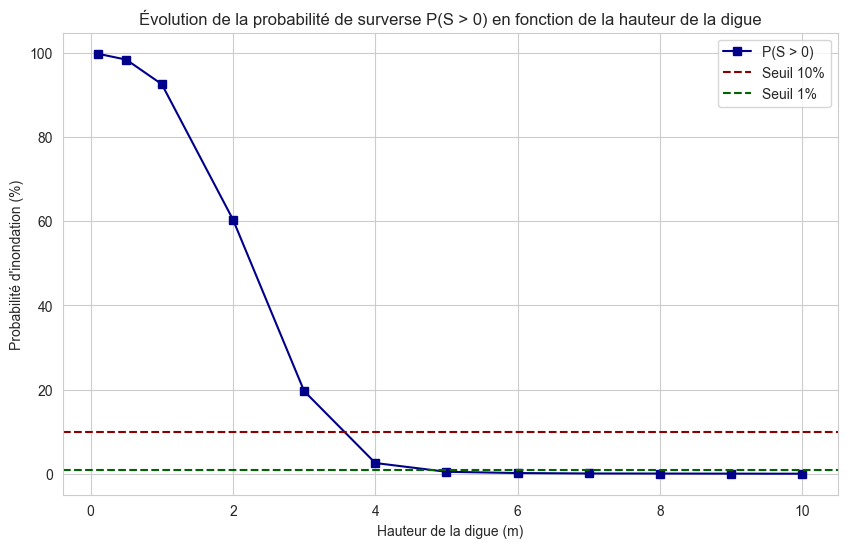

In [103]:
plt.figure(figsize=(10,6))
plt.plot(hauteurs_test, [P_inondation_hd[hd] * 100 for hd in hauteurs_test], marker='s', color="darkblue", label="P(S > 0)")

# Marquer les seuils choisis
plt.axhline(y=seuil_max_p_inondation_1 * 100, linestyle='--', color="darkred", label=f"Seuil {seuil_max_p_inondation_1:.0%}")
plt.axhline(y=seuil_max_p_inondation_2 * 100, linestyle='--', color="darkgreen", label=f"Seuil {seuil_max_p_inondation_2:.0%}")

plt.xlabel("Hauteur de la digue (m)")
plt.ylabel("Probabilité d'inondation (%)")
plt.title("Évolution de la probabilité de surverse P(S > 0) en fonction de la hauteur de la digue")
plt.legend()
plt.show()

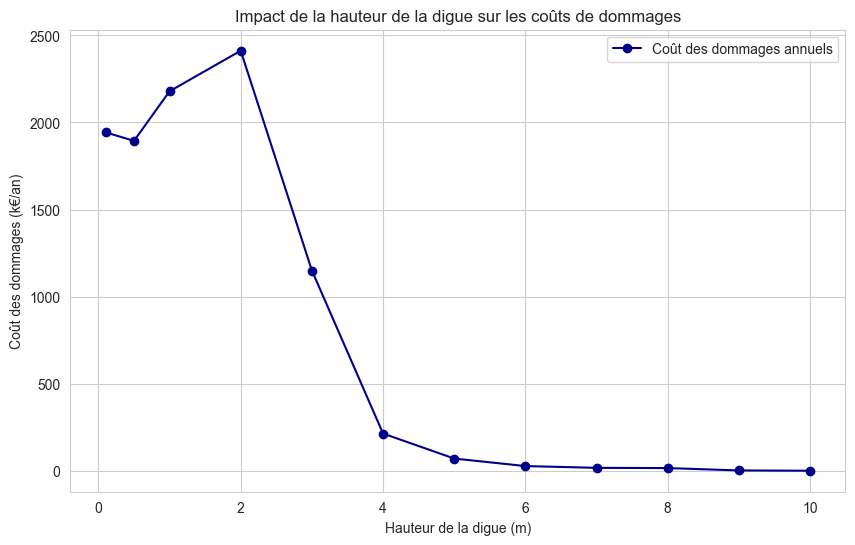

In [104]:
plt.figure(figsize=(10,6))
plt.plot(hauteurs_test, list(couts_dommages.values()), marker='o', color="darkblue", label="Coût des dommages annuels")

plt.xlabel("Hauteur de la digue (m)")
plt.ylabel("Coût des dommages (k€/an)")
plt.title("Impact de la hauteur de la digue sur les coûts de dommages")
plt.legend()
plt.show()

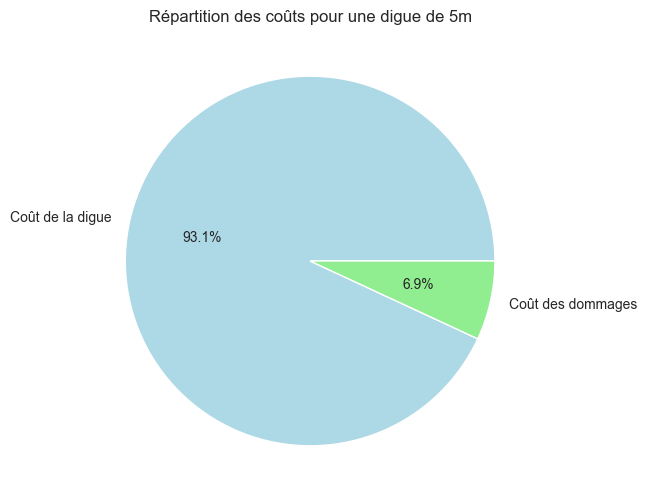

In [116]:
hd_opt = hauteur_optimale_2  # On prend la hauteur optimale avec le premier seuil
Ct_opt = couts_digue[hd_opt][2]  # Coût total de la digue
Cd_opt = couts_dommages[hd_opt] * T  # Coût cumulé des dommages sur 30 ans

plt.figure(figsize=(6,6))
plt.pie([Ct_opt, Cd_opt], labels=["Coût de la digue", "Coût des dommages"], autopct='%1.1f%%', colors=["lightblue", "lightgreen"])
plt.title(f"Répartition des coûts pour une digue de {hd_opt:.0f}m")
plt.show()